# NIJ Recidivism Data Analysis
https://data.ojp.usdoj.gov/Courts/NIJ-s-Recidivism-Challenge-Full-Dataset/ynf5-u8nk/about_data

## Step 1: Load Dataset and Assess Missing Values

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import rankdata
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.metrics import log_loss
from imblearn.under_sampling import RandomUnderSampler
from joblib import Parallel, delayed

In [136]:

# load the dataset
data = pd.read_csv('NIJ_s_Recidivism_Challenge_Full_Dataset_20241209.csv')

# calculate percentage of missing values
def calculate_missing_percentage(df):
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    return missing_percentage[missing_percentage > 0].sort_values(ascending=False)

missing_percentage = calculate_missing_percentage(data)
print("Percentage of Missing Values:")
print(missing_percentage)


Percentage of Missing Values:
Avg_Days_per_DrugTest           23.622992
DrugTests_THC_Positive          20.019354
DrugTests_Cocaine_Positive      20.019354
DrugTests_Meth_Positive         20.019354
DrugTests_Other_Positive        20.019354
Prison_Offense                  12.684343
Gang_Affiliated                 12.258564
Supervision_Level_First          6.657635
Jobs_Per_Year                    3.127540
Supervision_Risk_Score_First     1.838591
Percent_Days_Employed            1.788272
dtype: float64


## Step 2: Address Missing Values

In [137]:
# clean numerical columns with formatting issues
# replace commas and convert to numeric
columns_to_clean = ['Avg_Days_per_DrugTest', 'Jobs_Per_Year', 'Supervision_Risk_Score_First', 'Percent_Days_Employed']
for col in columns_to_clean:
    data[col] = data[col].replace({',': ''}, regex=True).astype(float)

# fill in missing values for Avg_Days_per_DrugTest
# use median
data['Avg_Days_per_DrugTest'].fillna(data['Avg_Days_per_DrugTest'].median(), inplace=True)

# fill in DrugTests_Positive columns with 0
# missing values probably indicate no positive test results
drug_test_columns = [
    'DrugTests_THC_Positive', 
    'DrugTests_Cocaine_Positive', 
    'DrugTests_Meth_Positive', 
    'DrugTests_Other_Positive'
]
data[drug_test_columns] = data[drug_test_columns].fillna(0)

# fill in Prison_Offense with 'Unknown'
# preserve missing as a valid category
data['Prison_Offense'].fillna('Unknown', inplace=True)

# fill in Gang_Affiliated with False
# missing probably means no gang affiliation
data['Gang_Affiliated'].fillna(False, inplace=True)

# fill in Supervision_Level_First with the mode
# replace missing with the most frequent value based on distributions
data['Supervision_Level_First'].fillna(data['Supervision_Level_First'].mode()[0], inplace=True)

# fill in Jobs_Per_Year with 0
# missing indicates no jobs
data['Jobs_Per_Year'].fillna(0, inplace=True)

# fill in Supervision_Risk_Score_First with the median
# median reduces bias
data['Supervision_Risk_Score_First'].fillna(data['Supervision_Risk_Score_First'].median(), inplace=True)

# fill in Percent_Days_Employed with 0
# missing implies no employment
data['Percent_Days_Employed'].fillna(0, inplace=True)

# handle any remaining missing values in the dataset
# fill numerical columns in with the median
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

# fill in categorical columns with the mode
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)

# check to ensure no missing values are left
print("Remaining missing values:")
print(data.isnull().sum().sum())  # should be 0
data_cleaned = data.copy(deep = True)

Remaining missing values:
0


## Step 3: Visualize Distributions

### Distribution by Race

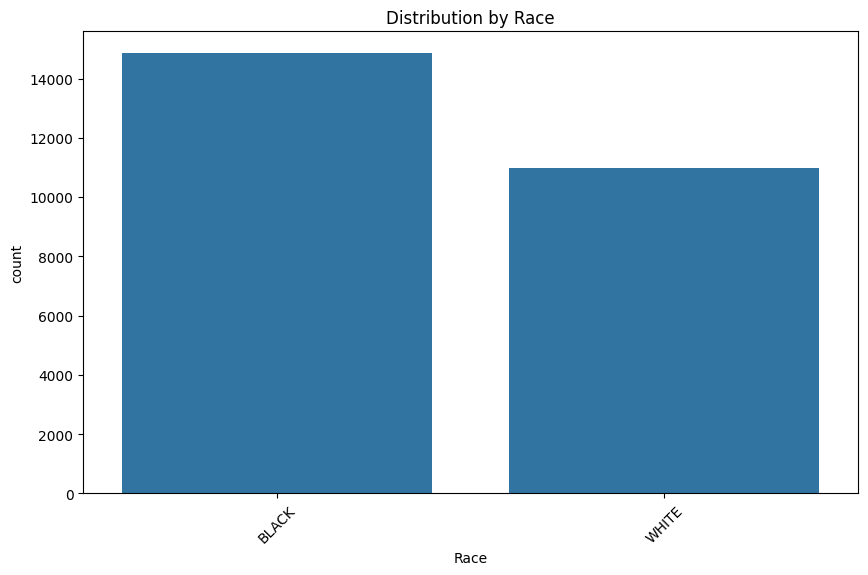

In [138]:

# distribution by race
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='Race', order=data_cleaned['Race'].value_counts().index)
plt.title("Distribution by Race")
plt.xticks(rotation=45)
plt.show()


### Distribution by Gender

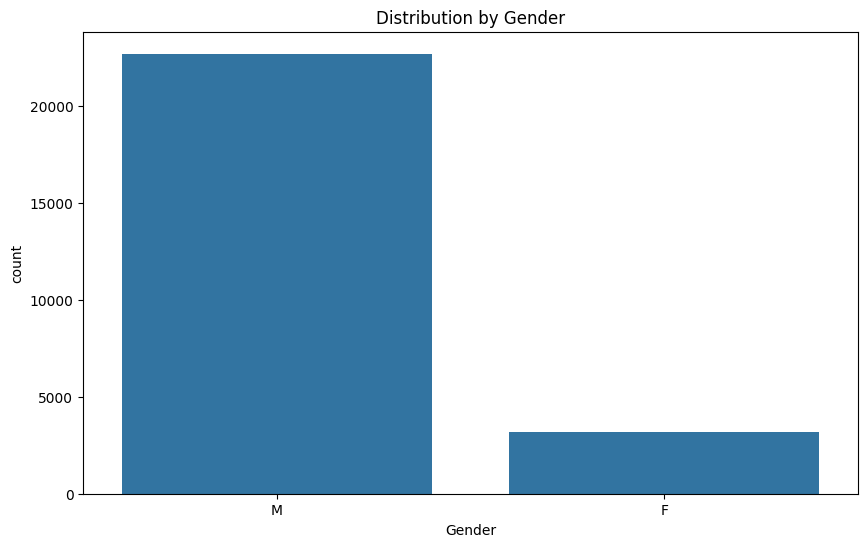

In [139]:

# distribution by gender
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='Gender')
plt.title("Distribution by Gender")
plt.show()


### Distribution by Age at Release

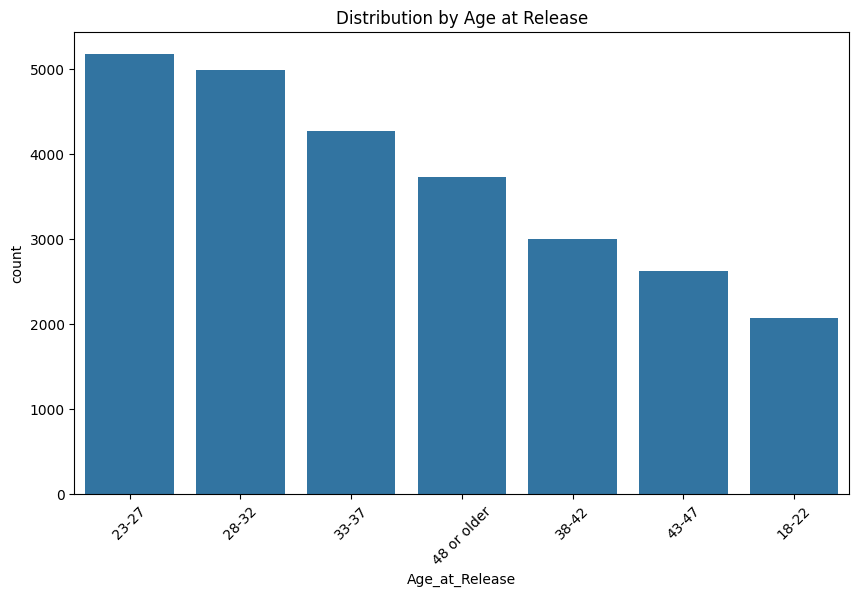

In [140]:

# distribution by age
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='Age_at_Release', order=data_cleaned['Age_at_Release'].value_counts().index)
plt.title("Distribution by Age at Release")
plt.xticks(rotation=45)
plt.show()


### Distribution by Geography (Residence PUMA)

Residence PUMA represents a geographic region defined by the U.S. Census Bureau with at least 100,000 people, used for statistical and demographic analysis.

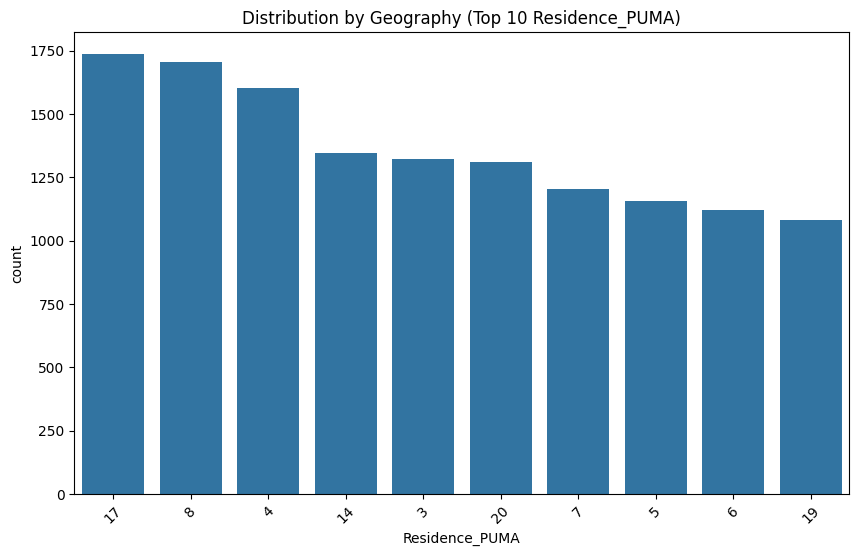

In [141]:

# distribution by geography (PUMA)
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='Residence_PUMA', order=data_cleaned['Residence_PUMA'].value_counts().index[:10])
plt.title("Distribution by Geography (Top 10 Residence_PUMA)")
plt.xticks(rotation=45)
plt.show()


## Step 4: Visualize Recidivism Rates

### Recidivism by Race

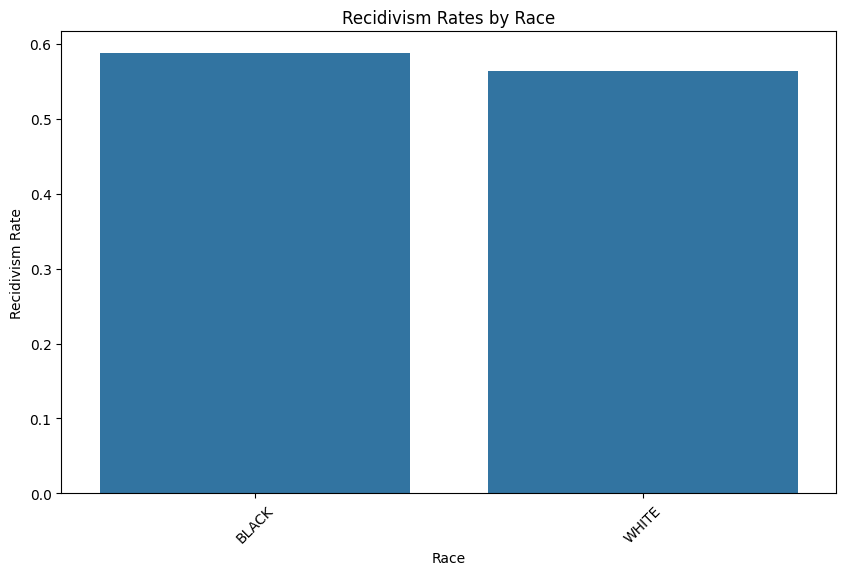

In [142]:
# recidivism by race
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data_cleaned.groupby('Race')['Recidivism_Within_3years'].mean().reset_index(),
    x='Race',
    y='Recidivism_Within_3years',
    order=data_cleaned['Race'].value_counts().index
)
plt.title("Recidivism Rates by Race")
plt.ylabel("Recidivism Rate")
plt.xticks(rotation=45)
plt.show()


### Recidivism by Gender

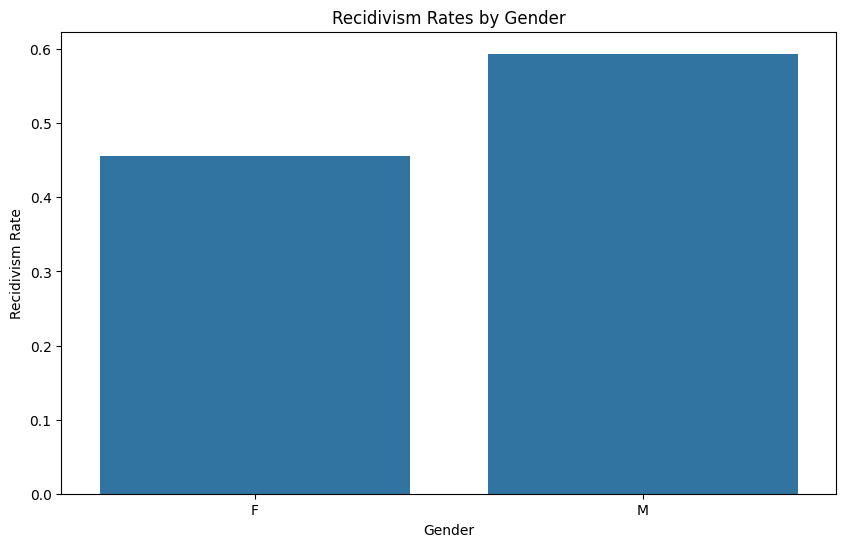

In [143]:

# recidivism by gender
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data_cleaned.groupby('Gender')['Recidivism_Within_3years'].mean().reset_index(),
    x='Gender',
    y='Recidivism_Within_3years'
)
plt.title("Recidivism Rates by Gender")
plt.ylabel("Recidivism Rate")
plt.show()


## Step 5: Encode Categorical Variables

In [144]:
# show unique values in each categorical column
for col in data_cleaned.select_dtypes(include=['object']).columns:
    print(f"{col}: {data_cleaned[col].unique()[:15]}")  # show the first 15 unique values


ID: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15']
Gender: ['M' 'F']
Race: ['BLACK' 'WHITE']
Age_at_Release: ['43-47' '33-37' '48 or older' '38-42' '18-22' '23-27' '28-32']
Supervision_Level_First: ['Standard' 'Specialized' 'High']
Education_Level: ['At least some college' 'Less than HS diploma' 'High School Diploma']
Dependents: ['3 or more' '1' '0' '2']
Prison_Offense: ['Drug' 'Violent/Non-Sex' 'Property' 'Unknown' 'Other' 'Violent/Sex']
Prison_Years: ['More than 3 years' '1-2 years' 'Less than 1 year'
 'Greater than 2 to 3 years']
Prior_Arrest_Episodes_Felony: ['6' '7' '8' '4' '10 or more' '3' '9' '2' '5' '1' '0']
Prior_Arrest_Episodes_Misd: ['6 or more' '4' '0' '1' '3' '5' '2']
Prior_Arrest_Episodes_Violent: ['1' '3 or more' '0' '2']
Prior_Arrest_Episodes_Property: ['3' '0' '2' '5 or more' '1' '4']
Prior_Arrest_Episodes_Drug: ['3' '2' '1' '0' '5 or more' '4']
Prior_Arrest_Episodes_PPViolationCharges: ['4' '5 or more' '3' '0' '1' '2']
Prior_Conviction_Episodes_F

In [145]:
# drop the 'ID' column
if 'ID' in data_cleaned.columns:
    data_cleaned.drop(columns=['ID'], inplace=True)

# make sure all values in 'Program_Attendances' are numeric
if 'Program_Attendances' in data_cleaned.columns:
    data_cleaned['Program_Attendances'] = pd.to_numeric(data_cleaned['Program_Attendances'], errors='coerce')
    data_cleaned['Program_Attendances'].fillna(data_cleaned['Program_Attendances'].median(), inplace=True)

In [146]:
# write out mappings for columns with explicit ranges or other categories
range_mappings = {
    'Age_at_Release': {
        '18-22': 20, '23-27': 25, '28-32': 30, '33-37': 35, '38-42': 40, '43-47': 45, '48 or older': 50
    },
    'Dependents': {
        '0': 0, '1': 1, '2': 2, '3 or more': 3
    },
    'Prior_Arrest_Episodes_Misd': {
        '6 or more': 6, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
    },
    'Prior_Arrest_Episodes_Violent': {
        '3 or more': 3, '0': 0, '1': 1, '2': 2
    },
    'Prior_Arrest_Episodes_Property': {
        '5 or more': 5, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4
    },
    'Prior_Arrest_Episodes_Drug': {
        '5 or more': 5, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4
    },
    'Prior_Arrest_Episodes_PPViolationCharges': {
        '5 or more': 5, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4
    },
    'Prior_Conviction_Episodes_Felony': {
        '3 or more': 3, '0': 0, '1': 1, '2': 2
    },
    'Prior_Conviction_Episodes_Misd': {
        '4 or more': 4, '0': 0, '1': 1, '2': 2, '3': 3
    },
    'Prior_Conviction_Episodes_Prop': {
        '3 or more': 3, '0': 0, '1': 1, '2': 2
    },
    'Prior_Conviction_Episodes_Drug': {
        '2 or more': 2, '0': 0, '1': 1
    },
    'Delinquency_Reports': {
        '4 or more': 4, '0': 0, '1': 1, '2': 2, '3': 3
    },
    'Program_UnexcusedAbsences': {
        '3 or more': 3, '0': 0, '1': 1, '2': 2
    },
    'Residence_Changes': {
        '3 or more': 3, '0': 0, '1': 1, '2': 2
    },
    'Prior_Arrest_Episodes_Felony': {
        '10 or more': 10, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9
    },
    'Program_Attendances': {
        '10 or more': 10, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '9': 9
    }
}

for col, mapping in range_mappings.items():
    if col in data_cleaned.columns:
        data_cleaned[col] = data_cleaned[col].replace(mapping)

# use LabelEncoder for text variables
label_encoders = {}
categorical_columns_to_encode = [
    'Gender', 'Race', 'Supervision_Level_First', 'Education_Level',
    'Prison_Offense', 'Prison_Years'
]

for col in categorical_columns_to_encode:
    if col in data_cleaned.columns:
        # initialize a new LabelEncoder for each column
        encoder = LabelEncoder()
        data_cleaned[col] = encoder.fit_transform(data_cleaned[col])
        label_encoders[col] = encoder
        # save encoder for mapping reference

In [147]:
# display first few rows to check
print(data_cleaned.head())

# show mappings for LabelEncoder columns
for col, encoder in label_encoders.items():
    print(f"Mapping for {col}: {dict(enumerate(encoder.classes_))}")


   Gender  Race  Age_at_Release  Residence_PUMA  Gang_Affiliated  \
0       1     0              45              16            False   
1       1     0              35              16            False   
2       1     0              50              24            False   
3       1     1              40              16            False   
4       1     1              35              16            False   

   Supervision_Risk_Score_First  Supervision_Level_First  Education_Level  \
0                           3.0                        2                0   
1                           6.0                        1                2   
2                           7.0                        0                0   
3                           7.0                        0                2   
4                           4.0                        1                2   

   Dependents  Prison_Offense  ...  DrugTests_Meth_Positive  \
0           3               0  ...                 0.000000   
1 

In [148]:
# check for any categorical values left
for col in data_cleaned.select_dtypes(include=['object']).columns:
    print(f"{col}: {data_cleaned[col].unique()[:15]}")

## Step 6: Filter Features

In [149]:
# review the features - exclude socioeconomic/race indicators to make model less biased than COMPAS
f_features = [
    'Race', 'Gender', 'Age_at_Release', 'Supervision_Risk_Score_First', 'Supervision_Level_First',
    'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
    'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
    'Prior_Arrest_Episodes_PPViolationCharges', 'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
    'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Viol',
    'Prior_Conviction_Episodes_Prop', 'Prior_Conviction_Episodes_Drug', 'Prior_Conviction_Episodes_PPViolationCharges',
    'Prior_Conviction_Episodes_DomesticViolenceCharges', 'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
    'Prior_Revocations_Probation', 'Violations_ElectronicMonitoring', 'Violations_Instruction', 'Violations_FailToReport',
    'Violations_MoveWithoutPermission', 'Delinquency_Reports', 'Residence_Changes', 'Avg_Days_per_DrugTest',
    'DrugTests_THC_Positive', 'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive', 'DrugTests_Other_Positive',
    'Percent_Days_Employed', 'Jobs_Per_Year', 'Employment_Exempt'
]

# filter 
f_data = data_cleaned[f_features]

## Step 7: Baseline LR Model

Played around with including and excluding different components to understand feature impact

In [16]:
from sklearn.metrics import confusion_matrix
# split the dataset into training and testing sets
target_column = 'Recidivism_Within_3years'
y = data_cleaned[target_column]
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(
    f_data, y, test_size=0.2, stratify=y
)

# make LR 
logistic_model_full = LogisticRegression(max_iter=10000)

# train
logistic_model_full.fit(X_train_LR, y_train_LR)

# predict
y_pred_LR = logistic_model_full.predict(X_test_LR)
y_pred_proba_LR = logistic_model_full.predict_proba(X_test_LR)[:, 1]

# metrics
accuracy_full = accuracy_score(y_test_LR, y_pred_LR)
f1_full = f1_score(y_test_LR, y_pred_LR)
roc_auc_full = roc_auc_score(y_test_LR, y_pred_proba_LR)

print("Logistic Regression Model Performance:")
print(f"Accuracy: {accuracy_full:.4f}")
print(f"F1 Score: {f1_full:.4f}")
print(f"ROC AUC: {roc_auc_full:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_LR, y_pred_LR))

# confusion matrix
cm = confusion_matrix(y_test_LR, y_pred_LR)
cm_df = pd.DataFrame(cm, index=["Actual No Recidivism", "Actual Yes Revidivism"], columns=["Predicted No Risk", "Predicted To Recidivise"])
print("Confusion Matrix:")
print(cm_df)

Logistic Regression Model Performance:
Accuracy: 0.7012
F1 Score: 0.7562
ROC AUC: 0.7515

Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.56      0.61      2186
        True       0.71      0.80      0.76      2981

    accuracy                           0.70      5167
   macro avg       0.70      0.68      0.69      5167
weighted avg       0.70      0.70      0.70      5167

Confusion Matrix:
                       Predicted No Risk  Predicted To Recidivise
Actual No Recidivism                1229                      957
Actual Yes Revidivism                587                     2394


## Step 8: Feature Engineering

In [114]:
# make a 2nd copy of the dataset for feature engineering
data_fe = data_cleaned.copy()

# 1. aggregate non-THC drug tests
data_fe['DrugTests_Positive'] = (
    data_fe['DrugTests_THC_Positive'] +
    data_fe['DrugTests_Cocaine_Positive'] +
    data_fe['DrugTests_Meth_Positive'] +
    data_fe['DrugTests_Other_Positive']
)

# 2. adjust program attendance
# subtract unexcused absences
data_fe['Program_Attendance_Adjusted'] = (
    data_fe['Program_Attendances'] - data_fe['Program_UnexcusedAbsences']
)

# 3. aggregate violations
# sum all of the types of violations
data_fe['Violations_Total'] = (
    data_fe['Violations_ElectronicMonitoring'] +
    data_fe['Violations_Instruction'] +
    data_fe['Violations_FailToReport'] +
    data_fe['Violations_MoveWithoutPermission']
)

# 4. weighted recency score
# give higher weights to more recent events
data_fe['Recency_Weighted_Score'] = (
    3 * data_fe['Prior_Revocations_Parole'] +
    2 * data_fe['Prior_Revocations_Probation'] +
    1 * data_fe['Delinquency_Reports']
)

# 5. aggregate prior arrests
# sum all prior arrests
data_fe['Prior_Arrest_Aggregate_Score'] = (
    data_fe['Prior_Arrest_Episodes_Felony'] +
    data_fe['Prior_Arrest_Episodes_Misd'] +
    data_fe['Prior_Arrest_Episodes_Violent'] +
    data_fe['Prior_Arrest_Episodes_Property'] +
    data_fe['Prior_Arrest_Episodes_Drug'] +
    data_fe['Prior_Arrest_Episodes_PPViolationCharges'] +
    data_fe['Prior_Arrest_Episodes_DVCharges'] +
    data_fe['Prior_Arrest_Episodes_GunCharges']
)

# 6. aggregate prior convictions
# sum all prior convictions
data_fe['Prior_Conviction_Aggregate_Score'] = (
    data_fe['Prior_Conviction_Episodes_Felony'] +
    data_fe['Prior_Conviction_Episodes_Misd'] +
    data_fe['Prior_Conviction_Episodes_Viol'] +
    data_fe['Prior_Conviction_Episodes_Prop'] +
    data_fe['Prior_Conviction_Episodes_Drug'] +
    data_fe['Prior_Conviction_Episodes_PPViolationCharges'] +
    data_fe['Prior_Conviction_Episodes_DomesticViolenceCharges'] +
    data_fe['Prior_Conviction_Episodes_GunCharges']
)

 7. aggregate employment
data_fe['Employment_Aggregate_Score'] = (
    data_fe['Percent_Days_Employed'] * data_fe['Jobs_Per_Year']
)

engineered_features = [
    'DrugTests_Positive', 'Program_Attendance_Adjusted', 'Violations_Total',
    'Recency_Weighted_Score', 'Prior_Arrest_Aggregate_Score', 'Prior_Conviction_Aggregate_Score',
    'Employment_Aggregate_Score'
]

# drop columns integrated into new features
integrated_columns = [
    'DrugTests_THC_Positive', 'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive', 'DrugTests_Other_Positive',
    'Program_Attendances', 'Program_UnexcusedAbsences', 'Violations_ElectronicMonitoring',
    'Violations_Instruction', 'Violations_FailToReport', 'Violations_MoveWithoutPermission',
    'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
    'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug', 'Prior_Arrest_Episodes_PPViolationCharges',
    'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges', 'Prior_Conviction_Episodes_Felony',
    'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
    'Prior_Conviction_Episodes_Drug', 'Prior_Conviction_Episodes_PPViolationCharges',
    'Prior_Conviction_Episodes_DomesticViolenceCharges', 'Prior_Conviction_Episodes_GunCharges'
]

# only keep relevant columns
# include original non/socioeconomic features, engineered features, and the target
retained_columns = (set(f_features) | set(engineered_features)) - set(integrated_columns)
data_fe = data_fe[[col for col in data_fe.columns if col in retained_columns]]
data_fe['Recidivism_Within_3years'] = data_cleaned['Recidivism_Within_3years']

# show a sample of the filtered dataset to check
print(f"Shape of the filtered dataset: {data_fe.shape}")
print(data_fe.head())


Shape of the filtered dataset: (25835, 22)
   Gender  Race  Age_at_Release  Supervision_Risk_Score_First  \
0       1     0              45                           3.0   
1       1     0              35                           6.0   
2       1     0              50                           7.0   
3       1     1              40                           7.0   
4       1     1              35                           4.0   

   Supervision_Level_First  Prison_Offense  Prison_Years  \
0                        2               0             3   
1                        1               4             3   
2                        0               0             0   
3                        0               2             0   
4                        1               4             0   

   Prior_Revocations_Parole  Prior_Revocations_Probation  Delinquency_Reports  \
0                     False                        False                    0   
1                     False                

## Step 9: Looping through Model
















Running Models + Grid Search: 100%|██████████| 100/100 [04:41<00:00,  2.82s/it]


    Iteration  Accuracy  F1 Score   ROC AUC  \
0           0  0.724792  0.776485  0.795096   
1           1  0.729824  0.782011  0.794768   
2           2  0.728276  0.781240  0.795770   
3           3  0.738727  0.787268  0.807249   
4           4  0.741436  0.791835  0.810724   
..        ...       ...       ...       ...   
95         95  0.722470  0.777881  0.785067   
96         96  0.738533  0.788012  0.805683   
97         97  0.730792  0.781048  0.797549   
98         98  0.725566  0.775987  0.801354   
99         99  0.731566  0.784192  0.799567   

                                          Best Params  True Positives  \
0   {'learning_rate': 0.07, 'max_depth': 5, 'n_est...            2470   
1   {'learning_rate': 0.07, 'max_depth': 5, 'n_est...            2504   
2   {'learning_rate': 0.07, 'max_depth': 5, 'n_est...            2507   
3   {'learning_rate': 0.05, 'max_depth': 5, 'n_est...            2498   
4   {'learning_rate': 0.05, 'max_depth': 5, 'n_est...            2541 

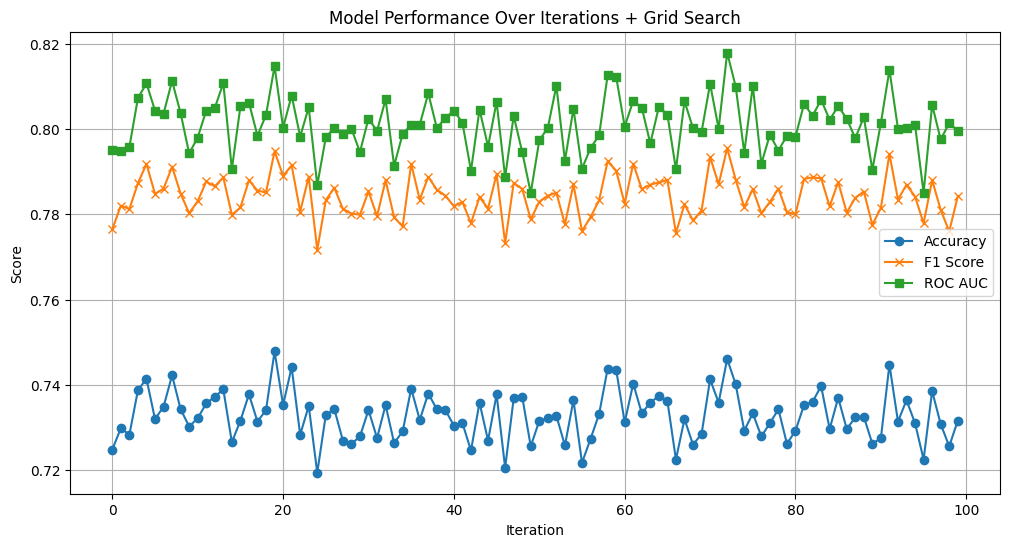


Best Parameters Based on All Iterations:
Parameters: {'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 200}
Occurrences: 35 times out of 100 iterations


In [225]:
# loop params
n_iterations = 100  
best_threshold = 0.4 

# define grid search params
param_grid = {
    'learning_rate': [0.05, 0.07, 0.09],
    'max_depth': [5, 7],
    'n_estimators': [200, 300]
}

# function for 1 iteration
def process_iteration(i, data_fe, param_grid, best_threshold):
    target_column = 'Recidivism_Within_3years'
    X = data_fe.drop(columns=[target_column])
    y = data_fe[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=i
    )
    undersampler = RandomUnderSampler(random_state=i)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
    
    X_train_features = X_train_resampled.drop(columns=['Race'])
    X_test_features = X_test.drop(columns=['Race'])

    # grid search for params
    xgb_model = XGBClassifier(eval_metric='logloss', random_state=i)
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=0,
        n_jobs=-1
    )
    grid_search.fit(X_train_features, y_train_resampled)
    
    # use the best model from grid search
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_features)
    y_pred_proba = best_model.predict_proba(X_test_features)[:, 1]
    
    # apply the custom threshold
    y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)
    
    # evaluate the model
    accuracy = accuracy_score(y_test, y_pred_optimized)
    f1 = f1_score(y_test, y_pred_optimized)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred_optimized)
    
    # adRac" back
    results = X_test.copy()
    results['True_Recidivism'] = y_test
    results['Predicted_Recidivism'] = y_pred_optimized
    results['Predicted_Probabilities'] = y_pred_proba

    # decile scores
    results['Decile_Score'] = (rankdata(results['Predicted_Probabilities'], method='average') / len(results)) * 10
    results['Decile_Score'] = results['Decile_Score'].astype(int)
    
    # metrics
    white_scores = results[results['Race'] == 1]['Decile_Score']
    black_scores = results[results['Race'] == 0]['Decile_Score']
    
    return {
        'Iteration': i,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Best Params': grid_search.best_params_,
        'True Positives': cm[1, 1],
        'True Negatives': cm[0, 0],
        'False Positives': cm[0, 1],
        'False Negatives': cm[1, 0],
        'White Decile Scores': white_scores.mean() if not white_scores.empty else np.nan,
        'Black Decile Scores': black_scores.mean() if not black_scores.empty else np.nan
    }

# parallelize the iterations
results_list = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i, data_fe, param_grid, best_threshold) for i in tqdm(range(n_iterations), desc="Running Models + Grid Search")
)

# results
results_df = pd.DataFrame(results_list)
print(results_df)

# metrics summary
summary_metrics = results_df[['Accuracy', 'F1 Score', 'ROC AUC']].mean()
print("Average Metrics Over Iterations:")
print(summary_metrics)

# visualize metrics
plt.figure(figsize=(12, 6))
plt.plot(results_df['Iteration'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(results_df['Iteration'], results_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(results_df['Iteration'], results_df['ROC AUC'], label='ROC AUC', marker='s')
plt.title("Model Performance Over Iterations + Grid Search")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

all_best_params = results_df['Best Params']
param_counts = Counter(map(str, all_best_params))
most_common_params = param_counts.most_common(1)

# most common best parameters
print("\nBest Parameters Based on All Iterations:")
print(f"Parameters: {most_common_params[0][0]}")
print(f"Occurrences: {most_common_params[0][1]} times out of {n_iterations} iterations")


## Step 10: Loss Function

Training with learning_rate=0.010
Training with learning_rate=0.031
Training with learning_rate=0.052
Training with learning_rate=0.073
Training with learning_rate=0.094
Training with learning_rate=0.116
Training with learning_rate=0.137
Training with learning_rate=0.158
Training with learning_rate=0.179
Training with learning_rate=0.200


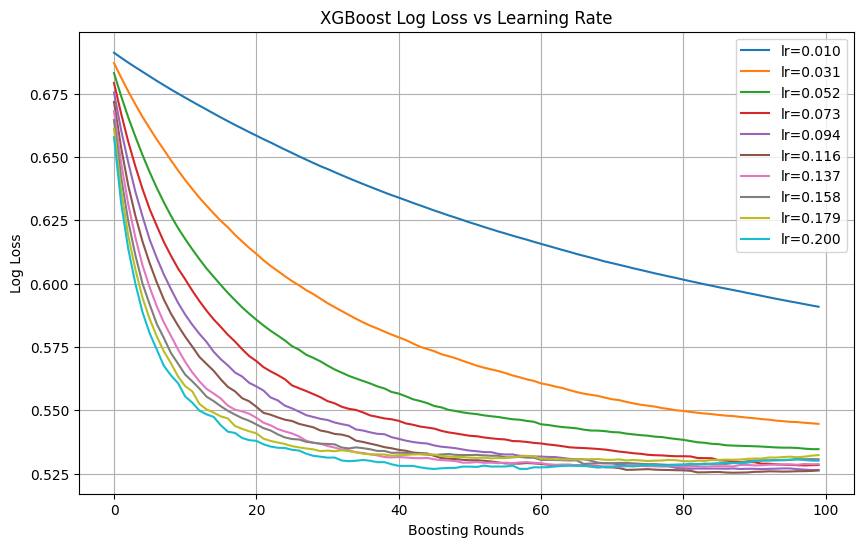

In [ ]:
# range of learning rates
learning_rates = np.linspace(0.01, 0.2, 10)  
num_boost_round = 100 
target_column = 'Recidivism_Within_3years'
results = {}

# split the data
X = data_fe.drop(columns=[target_column])
y = data_fe[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# undersampling
undersampler = RandomUnderSampler()
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# exclude race column
X_train_features = X_train_resampled.drop(columns=['Race'])
X_test_features = X_test.drop(columns=['Race'])

# evaluate models
for lr in learning_rates:
    print(f"Training with learning_rate={lr:.3f}")
    model = XGBClassifier(
        learning_rate=lr,
        n_estimators=num_boost_round,
        eval_metric='logloss'
    )
    eval_set = [(X_train_features, y_train_resampled), (X_test_features, y_test)]
    model.fit(
        X_train_features, y_train_resampled,
        eval_set=eval_set,
        verbose=False 
    )
    
    # store log loss
    train_loss = model.evals_result()['validation_0']['logloss']
    test_loss = model.evals_result()['validation_1']['logloss']
    results[lr] = {'train_loss': train_loss, 'test_loss': test_loss}

# plot loss curves
plt.figure(figsize=(10, 6))
for lr, loss in results.items():
    plt.plot(loss['test_loss'], label=f'lr={lr:.3f}')
plt.title('XGBoost Log Loss vs Learning Rate')
plt.xlabel('Rounds')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


## Step 11: Split Engineered Data for Final XGBoost

In [ ]:
# define target variable and features
target_column = 'Recidivism_Within_3years'
X = data_fe.drop(columns=[target_column])
y = data_fe[target_column]

# split the original data into training and testing
# test set keeps original class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# apply SMOTE to oversample the minority class in the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# keep specific column drop for training features
X_train_features = X_train_resampled.drop(columns=['Race'], errors='ignore')

# check splits
print(f"Training features shape: {X_train_resampled.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train_resampled.shape}")
print(f"Testing target shape: {y_test.shape}")

# check class distribution
print("\nClass distribution in training data after SMOTE:")
print(y_train_resampled.value_counts())

print("\nClass distribution in testing data (unchanged):")
print(y_test.value_counts())

Training features shape: (23846, 21)
Testing features shape: (5167, 21)
Training target shape: (23846,)
Testing target shape: (5167,)

Class distribution in training data after SMOTE:
Recidivism_Within_3years
True     11923
False    11923
Name: count, dtype: int64

Class distribution in testing data (unchanged):
Recidivism_Within_3years
True     2981
False    2186
Name: count, dtype: int64


## Step 12: Grid Search

In [156]:
# model for grid search
xgb_modelT = XGBClassifier(eval_metric='logloss')

# parameter grid
param_grid = {
    'n_estimators': [180, 200, 220, 240, 260, 280, 300],
    'max_depth': [4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11]
}

# initialize gridsearchCV
grid_searchT = GridSearchCV(
    estimator=xgb_modelT,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=0,
    n_jobs=-1,
)

# grid search
grid_searchT.fit(X_train_features, y_train_resampled)

# show best parameters and best score
print("Best Parameters:", grid_searchT.best_params_)
print("Best ROC AUC Score:", grid_searchT.best_score_)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 260}
Best ROC AUC Score: 0.8106051230483793


## Step 13: Run Final XGBoost

In [220]:
# initialize final model
final_xgb_model = XGBClassifier(
    learning_rate=0.09,
    max_depth=7,
    n_estimators=280,
    eval_metric='logloss',
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    reg_lambda=2, 
    reg_alpha=1
)

# train on training data
final_xgb_model.fit(X_train_features, y_train_resampled)
X_test_features = X_test.drop(columns=['Recidivism_Within_3years', 'Race'], errors='ignore')

# make predictions on test set
y_pred = final_xgb_model.predict(X_test_features)
y_pred_proba = final_xgb_model.predict_proba(X_test_features)[:, 1]

## Step 14: Model Evaluation

In [221]:
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Final XGBoost Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Final XGBoost Model Performance:
Accuracy: 0.7155
F1 Score: 0.7472
ROC AUC: 0.7885

Classification Report:
              precision    recall  f1-score   support

       False       0.65      0.70      0.67      2186
        True       0.77      0.73      0.75      2981

    accuracy                           0.72      5167
   macro avg       0.71      0.71      0.71      5167
weighted avg       0.72      0.72      0.72      5167



In [ ]:
# recalculate with context-dependant threshold
best_threshold = 0.4 

# apply the best threshold
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

# recalculate performance metrics
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_pred_optimized)

# show all metrics
print("\nPerformance with Optimized Threshold:")
print(f"Accuracy: {accuracy_optimized:.4f}")
print(f"F1 Score: {f1_optimized:.4f}")
print(f"ROC AUC: {roc_auc_optimized:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_optimized)
cm_df = pd.DataFrame(cm, index=["Actual No Recidivism", "Actual Yes Revidivism"], columns=["Predicted No Risk", "Predicted To Recidivise"])
print("Confusion Matrix:")
print(cm_df)



Performance with Optimized Threshold:
Accuracy: 0.7256
F1 Score: 0.7733
ROC AUC: 0.7100

Classification Report:
              precision    recall  f1-score   support

       False       0.70      0.61      0.65      2186
        True       0.74      0.81      0.77      2981

    accuracy                           0.73      5167
   macro avg       0.72      0.71      0.71      5167
weighted avg       0.72      0.73      0.72      5167

Confusion Matrix:
                       Predicted No Risk  Predicted To Recidivise
Actual No Recidivism                1331                      855
Actual Yes Revidivism                563                     2418


## Step 15: COMPAS-Comparable Evaluation

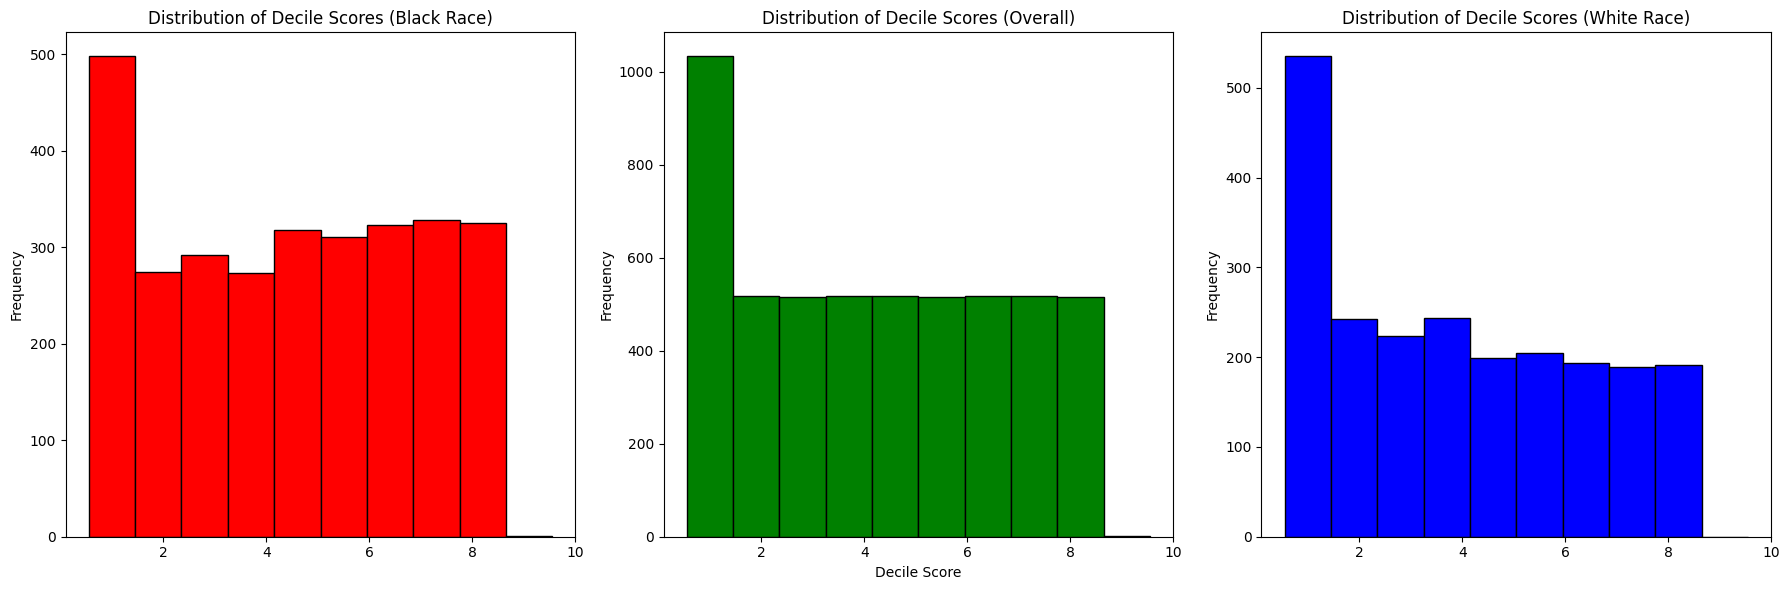

In [222]:
# normalize predicted probabilities to percentile scores
percentile_scores = rankdata(y_pred_proba, method='average') / len(y_pred_proba)

# scale percentile scores to deciles (1 to 10)
decile_scores = (percentile_scores * 10).astype(int)
decile_scores[decile_scores == 0] = 1

# results DataFrame for analysis
results = X_test.copy()
results['True_Recidivism'] = y_test
results['Predicted_Recidivism'] = y_pred
results['Predicted_Probabilities'] = y_pred_proba
results['Decile_Score'] = decile_scores

# filter data by race
white_scores = results[results['Race'] == 1]['Decile_Score']
black_scores = results[results['Race'] == 0]['Decile_Score']
overall_scores = results['Decile_Score']

# set up the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# AA dist
axes[0].hist(black_scores, bins=10, range=(1, 10), edgecolor='black', align='left', color='red')
axes[0].set_title('Distribution of Decile Scores (Black Race)')
axes[0].set_ylabel('Frequency')

# overall dist
axes[1].hist(overall_scores, bins=10, range=(1, 10), edgecolor='black', align='left', color='green')
axes[1].set_title('Distribution of Decile Scores (Overall)')
axes[1].set_ylabel('Frequency')

# caucasian dist
axes[2].hist(white_scores, bins=10, range=(1, 10), edgecolor='black', align='left', color='blue')
axes[2].set_title('Distribution of Decile Scores (White Race)')
axes[2].set_ylabel('Frequency')
axes[1].set_xlabel('Decile Score')

plt.tight_layout()
plt.show()


In [223]:
# helper function
def calculate_metrics(data, threshold=4):
    # binary predictions based on the established threshold
    predictions = (data['Decile_Score'] > threshold).astype(int)
    
    # true
    true_labels = data['True_Recidivism']
    
    # metrics
    accuracy = (predictions == true_labels).mean()
    false_positive_rate = ((predictions == 1) & (true_labels == 0)).sum() / (true_labels == 0).sum()
    false_negative_rate = ((predictions == 0) & (true_labels == 1)).sum() / (true_labels == 1).sum()
    
    return accuracy, false_positive_rate, false_negative_rate

# filter data by race
white_data = results[results['Race'] == 1]
black_data = results[results['Race'] == 0]
overall_data = results

# metrics for each group
white_metrics = calculate_metrics(white_data)
black_metrics = calculate_metrics(black_data)
overall_metrics = calculate_metrics(overall_data)

# make df
metrics_df = pd.DataFrame({
    'Group': ['African-American', 'Overall', 'Caucasian'],
    'Accuracy': [black_metrics[0], overall_metrics[0], white_metrics[0]],
    'False Positive Rate': [black_metrics[1], overall_metrics[1], white_metrics[1]],
    'False Negative Rate': [black_metrics[2], overall_metrics[2], white_metrics[2]]
})

metrics_df

,Group,Accuracy,False Positive Rate,False Negative Rate
0,African-American,0.710839,0.302760,0.279369
1,Overall,0.706793,0.255718,0.320698
2,Caucasian,0.701439,0.194969,0.376378


PCA is unnecessary and remove - education level?? 0 -> 2 -> 1
prison offense, drug, etc

linear regression - doesn't work with pca obv

xgboost justification - basically random forest but individual trees are stronger predictors

xgboost refinement - pay more attention to the training (overfitting)
    look at confusion matrices 
    get rid of random state variable and put entire model (starting step 9) into a loop to run 1000 times
    assemble statistics each time without a random state
    grid search loop as well (n_estimators/max_depth is most important, learning rate is still needed (look at loss function), delete other params)
    look at confusion matrix
    optimize params across all random states (he got to 91)
oversampler should copy other minority vals or reflect distribution of minority vals - so need to change oversampler 
undersampling instead - throw away majority data, and then apply a weight of n to each row to make it n* more important
